"""
Implements an RNN on a synthetic data set, following the architecture 
described in "Deep Knowledge Tracing" by Chris Piech et al.
The RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).
BSD License
"""

In [1]:
# Python libraries
import numpy as np
import random
import sys
import csv
import matplotlib.pyplot as plt
# allows plots to show inline in ipython notebook
%matplotlib inline

# our own modules
import utils

synthetic_data_set = "syntheticDetailed/naive_c5_q50_s4000_v0.csv"

In [2]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(synthetic_data_set,"rb"),delimiter=','))).astype('int')
data_array = data_array[:500]
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 
# Split data into train and test (half and half)
train = data_array[0:num_samples/2,:]
test = data_array[num_samples/2:num_samples,:]

num_train = train.shape[0]
num_test = test.shape[0]

print('Vectorization...')
X_train, y_train, corr_train = utils.vectorize_syn_data(train, num_timesteps)
X_test, y_test, corr_test = utils.vectorize_syn_data(test, num_timesteps)
print ("Vectorization done!")


Vectorization...
Vectorization done!


In [3]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-1
epochs = 40

# model parameters
Wxh = np.random.randn(hidden_size, num_problems * 2)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(num_problems, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((num_problems, 1)) # output bias

def lossFun(inputs, targets, correctness, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars

        # softmax (cross-entropy loss)
        if correctness[targets[t]] == 1:
            loss += -np.log(ps[t][targets[t],0]) 
        else:
            loss += -np.log(1-ps[t][targets[t],0]) 
        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dhnext = np.zeros_like(hs[0])


    for t in reversed(xrange(len(inputs))):
        dy = np.copy(ps[t])
        if correctness[targets[t]] == 1:
            dy[targets[t]] -= 1 # backprop into y
        else:
            for p in xrange(num_problems):
                if p != targets[t]:
                    dy[p] -= np.exp(ys[t][p]) / (ps_denom[t] - np.exp(ys[t][targets[t]]))



        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


In [4]:
def accuracy(ps, targets, correctness):
    """
    Computes the accuracy using the predictions at each time step.
    For each t, if probability of next problem is > 0.5 for correct, or <= 0.5 
    for incorrect, then count this as correct prediction.
    """
    num_correct = 0
    for t in xrange(num_timesteps):
        predicted_prob = ps[t][targets[t],0] 
        if (predicted_prob >= 0.5 and correctness[targets[t]] == 1) or (predicted_prob < 0.5 and correctness[targets[t]] == 0):
            num_correct += 1
    accuracy = num_correct / float(num_timesteps)
    return accuracy

def forward_pass(inputs):
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars
    return ps

In [5]:
def extract_x_y_corr_for_sample(X, y, corr):
    num_timesteps = X.shape[1]
    num_problems = corr.shape[1]
    inputs = X[i,:,:].reshape((num_timesteps, num_problems * 2))
    targets = y[i,:].reshape((num_timesteps,))
    correctness = corr[i,:].reshape((num_problems))
    return inputs, targets, correctness

In [ ]:

mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/num_problems)*num_timesteps # loss at iteration 0

losses = []
train_accuracies = []
test_accuracies = []
print_batch_sz = 20
for e in xrange(epochs):
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    total_acc_train = 0.0
    total_acc_test = 0.0
    for i in xrange(num_train):
        inputs_train, targets_train, correctness_train = extract_x_y_corr_for_sample(X_train, y_train, corr_train)
        # forward num_timesteps characters through the net and fetch gradient
        loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs_train, targets_train, correctness_train, hprev)
        smooth_loss = smooth_loss * 0.7 + loss * 0.3
        losses.append(smooth_loss)

        # perform parameter update with Adagrad
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                      [dWxh, dWhh, dWhy, dbh, dby], 
                                      [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
        ps_train = forward_pass(inputs_train)
        acc_train = accuracy(ps_train, targets_train, correctness_train)
        train_accuracies.append(acc_train)
        
        if i%print_batch_sz == 0 and i != 0:
            print ('epoch %d, iter %d, loss: %f, train acc: %f' % (e, i, smooth_loss, acc_train)) 
            
        total_acc_train += acc_train
    total_acc_train /= num_train
        
    for i in xrange(num_test):
        inputs_test, targets_test, correctness_test = extract_x_y_corr_for_sample(X_test, y_test, corr_test)
        ps_test = forward_pass(inputs_test)
        acc_test = accuracy(ps_test, targets_test, correctness_test) 
        test_accuracies.append(acc_test)
        total_acc_test += acc_test
    
    total_acc_test /= num_test
    print ('epoch %d, train acc: %f, test acc: %f' % (e, total_acc_train, total_acc_test)) # print progress
    

epoch 0, iter 20, loss: 306.298537, train acc: 0.102041
epoch 0, iter 40, loss: 161.828249, train acc: 0.448980
epoch 0, iter 60, loss: 172.151292, train acc: 0.346939
epoch 0, iter 80, loss: 175.268805, train acc: 0.061224
epoch 0, iter 100, loss: 134.441745, train acc: 0.612245
epoch 0, iter 120, loss: 124.909992, train acc: 0.387755
epoch 0, iter 140, loss: 119.775909, train acc: 0.469388
epoch 0, iter 160, loss: 125.154584, train acc: 0.530612
epoch 0, iter 180, loss: 152.902720, train acc: 0.204082
epoch 0, iter 200, loss: 117.893093, train acc: 0.551020
epoch 0, iter 220, loss: 113.688187, train acc: 0.653061
epoch 0, iter 240, loss: 112.579918, train acc: 0.265306
epoch 0, train acc: 0.380245, test acc: 0.397714
epoch 1, iter 20, loss: 136.607899, train acc: 0.102041
epoch 1, iter 40, loss: 89.412291, train acc: 0.448980
epoch 1, iter 60, loss: 96.575266, train acc: 0.346939
epoch 1, iter 80, loss: 92.889443, train acc: 0.122449
epoch 1, iter 100, loss: 64.893429, train acc: 0.5

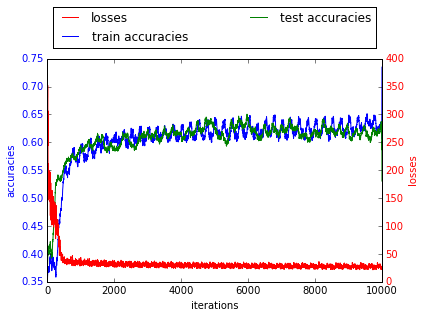

In [ ]:

def smoothen_data(data, smooth_window=100):
    smooth = []
    for i in xrange(len(data)-smooth_window):
        smooth.append(np.mean(data[i:i+smooth_window]))

    for i in xrange(len(data)-smooth_window, len(data)):
        smooth.append(np.mean(data[i:len(data)]))
    return smooth
   
smooth_accs_train = smoothen_data(train_accuracies)
smooth_accs_test = smoothen_data(test_accuracies)
                    
fig = plt.figure()

ax1 = fig.add_subplot(111)
train_accs_line, = ax1.plot(xrange(len(smooth_accs_train)), smooth_accs_train, 'b-', label='train accuracies')
test_accs_line, = ax1.plot(xrange(len(smooth_accs_test)), smooth_accs_test, 'g-', label='test accuracies')
ax1.set_ylabel('accuracies', color='b')
ax1.set_xlabel('iterations')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
losses_line, = ax2.plot(xrange(len(losses)), losses, 'r-', label='losses')
ax2.set_ylabel('losses', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.legend(handles=[losses_line, train_accs_line, test_accs_line],bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand")
# plt.legend([losses_line, train_accs_line, test_accs_line], ['losses', 'train accuracies', 'test accuracies'])
plt.show()